# Diabetes Dataset

In [1]:
from Functions import *

In [2]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA, FastICA
from sklearn.random_projection import GaussianRandomProjection
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectFromModel
import scipy
from scipy.linalg import pinv
from sklearn.preprocessing import scale
from sklearn.model_selection import KFold, train_test_split, validation_curve, GridSearchCV, learning_curve
from sklearn.metrics import silhouette_score, adjusted_mutual_info_score, silhouette_samples, mean_squared_error, accuracy_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
import warnings
import time

warnings.filterwarnings('ignore')
pd.set_option('max_columns', None)

In [46]:
df.shape

(12465, 22)

In [3]:
df = pd.read_csv('data/diabetes_train.csv').drop('Unnamed: 0', axis=1)
target_col = 'Diabetes'
X = scale(df.drop(target_col, axis=1))
y = df[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
kf = KFold(5)

# k-Means

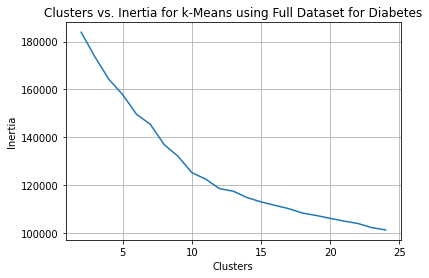

In [6]:
s_scores = plot_inertia(X, 'Full Dataset', target_col, split=True)

> **intertia**: Inertia measures how well a dataset was clustered by K-Means. It is calculated by measuring the distance between each data point and its centroid, squaring this distance, and summing these squares across one cluster.

>A good model is one with low inertia AND a low number of clusters (K). However, this is a tradeoff because as K increases, inertia decreases.

>To find the optimal K for a dataset, use the Elbow method; find the point where the decrease in inertia begins to slow

[source](https://www.codecademy.com/learn/machine-learning/modules/dspath-clustering/cheatsheet)

### Plotting Silhouette Scores

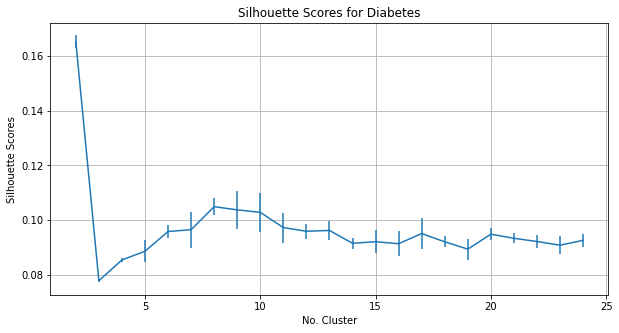

In [47]:
s_scores_df = pd.DataFrame(s_scores)
fig, ax = plt.subplots(figsize=(10,5))
s_avgs = s_scores_df.groupby('cluster').mean()
ax.errorbar(s_avgs.index, s_avgs['silhouette score'], yerr=s_scores_df.groupby('cluster').std()['silhouette score'])
ax.set_title(f'Silhouette Scores for {target_col}')
ax.set_ylabel('Silhouette Scores')
ax.set_xlabel('No. Cluster')
ax.grid();

> **silhouette score**: The value of the silhouette *coefﬁcient* is between [-1, 1]. A score of 1 denotes the best meaning that the data point i is very compact within the cluster to which it belongs and far away from the other clusters. The worst value is -1. Values near 0 denote overlapping clusters.

Inertia          :  166566.99955819795
Silhouette score :  0.11089463284217606
AMI score        :  0.09393579589545373
Cluster 0:
	True  : 75.0%
	False : 25.0%
Cluster 1:
	True  : 18.0%
	False : 82.0%
Cluster 2:
	True  : 58.0%
	False : 42.0%
Cluster 3:
	True  : 47.0%
	False : 53.0%
Cluster 4:
	True  : 64.0%
	False : 36.0%
Cluster 5:
	True  : 78.0%
	False : 22.0%
Cluster 6:
	True  : 27.0%
	False : 73.0%
Cluster 7:
	True  : 7.0%
	False : 93.0%


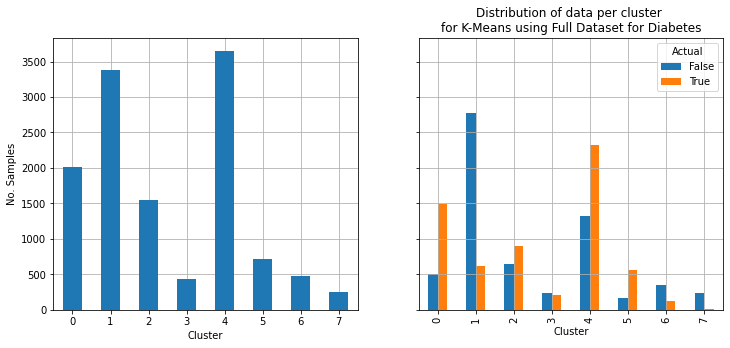

In [90]:
kmeans_cluster = plot_kmeans_cluster_dist(8, X, y, 'Full Dataset', target_col);
get_cluster_breakdown(kmeans_cluster.labels_, y)

Adjusted Mutual Information (AMI) is an adjustment of the Mutual Information (MI) score to account for chance. It accounts for the fact that the MI is generally higher for two clusterings with a larger number of clusters, regardless of whether there is actually more information shared. For two clusterings  and , the AMI is given as:

$AMI(U, V) = [MI(U, V) - E(MI(U, V))] / [avg(H(U), H(V)) - E(MI(U, V))]$
This metric is independent of the absolute values of the labels: a permutation of the class or cluster label values won’t change the score value in any way.

This metric is furthermore symmetric: switching  (label_true) with  (labels_pred) will return the same score value. This can be useful to measure the agreement of two independent label assignments strategies on the same dataset when the real ground truth is not known.
[sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_mutual_info_score.html)

# GMM
>A Gaussian mixture model (GMM) attempts to find a mixture of multi-dimensional Gaussian probability distributions that best model any input dataset. In the simplest case, GMMs can be used for finding clusters in the same manner as k-means [source--don't reference](https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html)

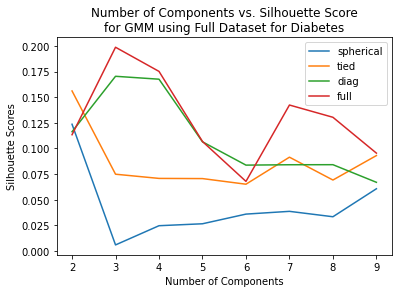

In [57]:
min_comps, max_comps = 2, 10
best_gmm, bic = run_gmm(X, n_comps=range(min_comps,max_comps))
plot_bic(bic, 'GMM', data_set='Full Dataset', target_col=target_col, n_comps=range(min_comps,max_comps))

>**Bayesian information criterion (BIC)**: This criterion gives us an estimation on how much is good the GMM in terms of predicting the data we actually have. The lower is the BIC, the better is the model to actually predict the data we have, and by extension, the true, unknown, distribution. In order to avoid overfitting, this technique penalizes models with big number of clusters.

For n_clusters = 3 
The average silhouette_score is : 0.19861463940278357


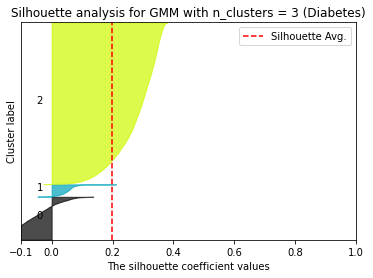

In [58]:
n_clusters = best_gmm.n_components
fig, (ax1) = plt.subplots(1, 1)
ax1.set_xlim([-0.1, 1])
ax1.set_ylim([0, len(X) + (n_clusters + 1) * 12])
clusterer = GaussianMixture(n_components=n_clusters, covariance_type=best_gmm.covariance_type)
cluster_labels = clusterer.fit_predict(X)
silhouette_avg = silhouette_score(X, cluster_labels)
print(
    "For n_clusters =",
    n_clusters,
    "\nThe average silhouette_score is :",
    silhouette_avg,
)
sample_silhouette_values = silhouette_samples(X, cluster_labels)

y_lower = 10
for i in range(n_clusters):
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7,
    )
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10 

ax1.set_title(f"Silhouette analysis for GMM with n_clusters = {n_clusters} ({target_col})")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")
ax1.axvline(x=silhouette_avg, color="red", linestyle="--", label='Silhouette Avg.')
ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
ax1.legend()
plt.show()

Silhouette score :  0.19879945200522842
AMI score        :  0.025937532267311412


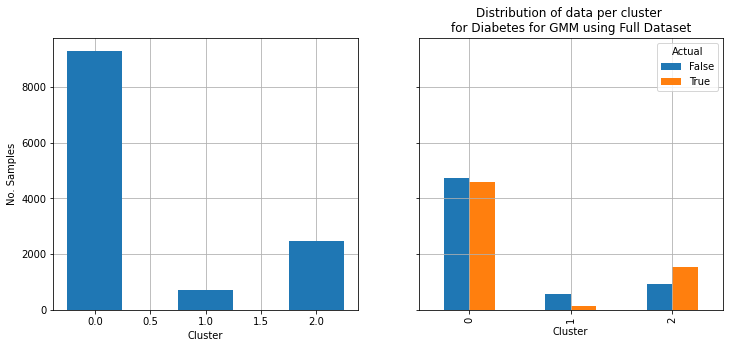

In [82]:
plot_cluster_dist(best_gmm, X, y, 'GMM', 'Full Dataset', target_col)

# PCA

PCA is designed for continuous variables. It tries to minimize variance (=squared deviations). The concept of squared deviations breaks down when you have binary variables.

In [12]:
pca = PCA(random_state=0)
pca.fit(X);

In [76]:
def plot_pca_variance(pca, target_col='Diabetes'):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
    ax1.plot(np.arange(1, pca.explained_variance_.size + 1), pca.explained_variance_)
    ax1.set_xticks(np.arange(1, pca.explained_variance_ratio_.size + 1, 2))
    ax1.set_xlabel('Eigenvalue Number')
    ax1.set_ylabel('Eigenvalue Size')
    ax1.set_title(f'Eigenvalues Number vs Size\n for {target_col}')
    ax1.grid()

    ax2.bar(np.arange(1, pca.explained_variance_ratio_.size + 1), pca.explained_variance_ratio_)
#     ax2.plot(np.arange(1, pca.explained_variance_ratio_.size + 1), pca.explained_variance_ratio_, label='Variance')
    ax2.plot(np.arange(1, pca.explained_variance_ratio_.size + 1), np.cumsum(pca.explained_variance_ratio_), color='orange', label='Cumulative Variance')
    ax2.axhline(0.85, linestyle='--', color='red')
    ax2.set_xticks(np.arange(1, pca.explained_variance_ratio_.size + 1, 1))
    ax2.set_xlabel('Component')
    ax2.set_ylabel('Variance')
    ax2.set_title(f'Cumulative Variance vs.\nPCA Component for {target_col}')
    ax2.legend()
    ax2.grid()
    plt.tight_layout()

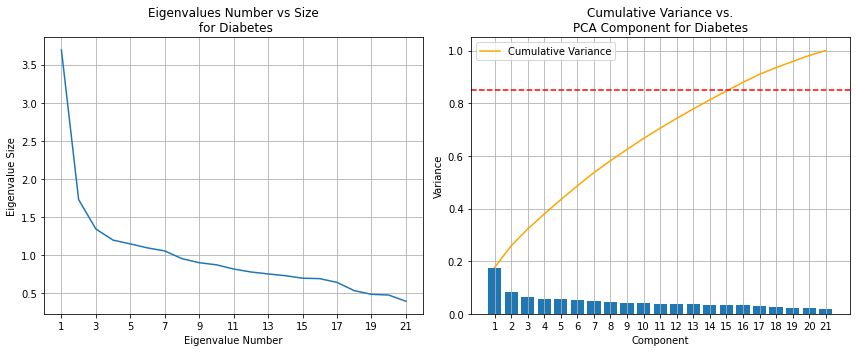

In [77]:
plot_pca_variance(pca, target_col)

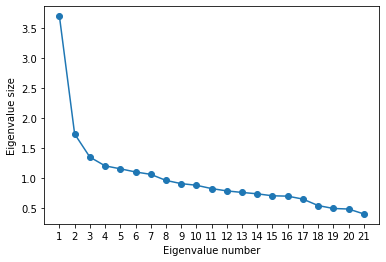

In [73]:
plt.plot(pca.explained_variance_, marker='o')
plt.xlabel("Eigenvalue number")
plt.ylabel("Eigenvalue size")
plt.xticks(range(len(pca.explained_variance_)), range(1, len(pca.explained_variance_)+1));

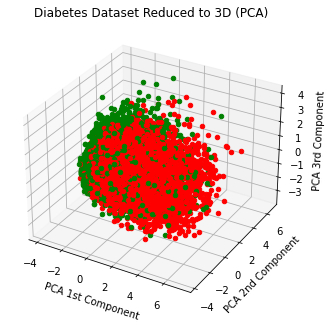

In [78]:
X_PCA = PCA(n_components = .85).fit_transform(X)
X_PCA_train, X_PCA_test, y_PCA_train, y_PCA_test = train_test_split(X_PCA, y, test_size=0.3, random_state=0)
plot_3d(X_PCA, y, target_col=target_col, dataset='PCA')

# ICA

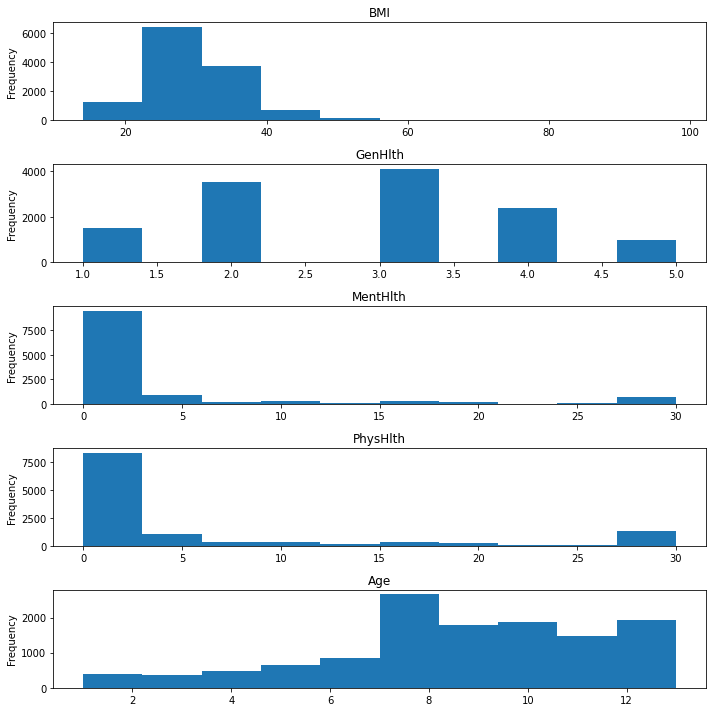

In [92]:
fig, ax = plt.subplots(5, figsize=(10,10))
i=0
for col in df.columns:
    try:
        df[col].plot.hist(ax=ax[i], title=col)
        i+=1
    except:pass
plt.tight_layout()

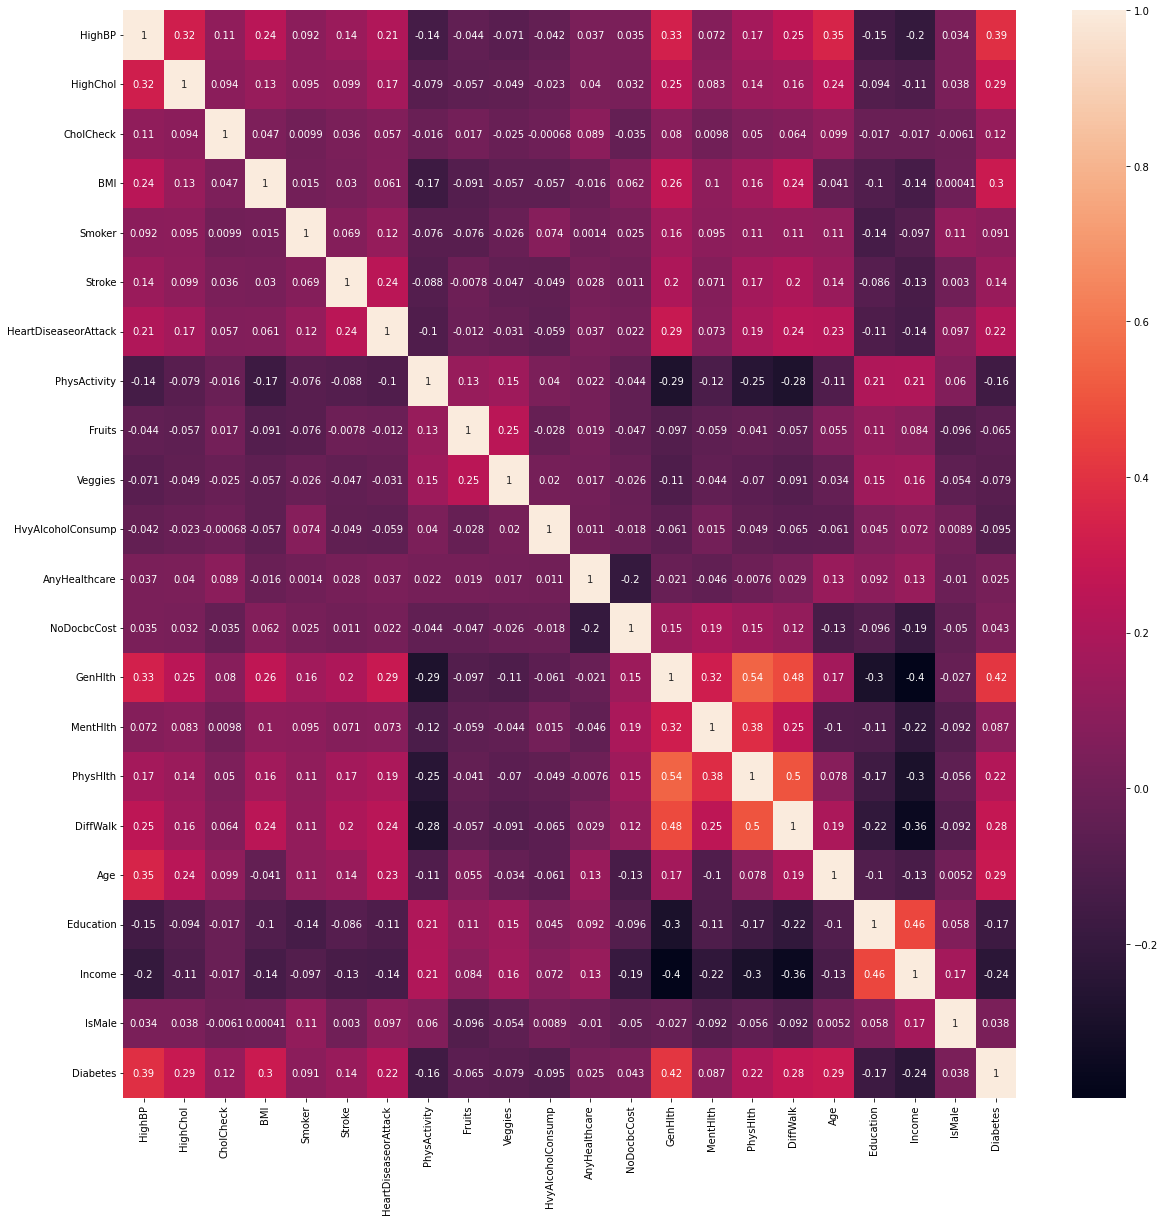

In [95]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(df.corr(), annot=True, ax=ax);

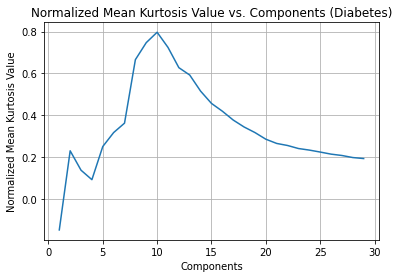

In [15]:
kurtosis_values = plot_kurtosis_values(X, target_col=target_col)

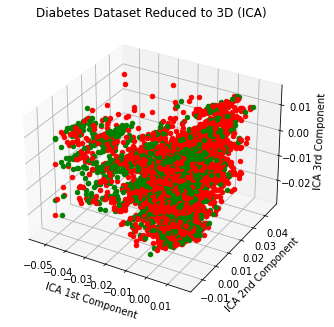

In [16]:
X_ICA = FastICA(n_components = np.argmax(kurtosis_values)+1).fit_transform(X)
X_ICA_train, X_ICA_test, y_ICA_train, y_ICA_test = train_test_split(X_ICA, y, test_size=0.3, random_state=0)
plot_3d(X_ICA, y, target_col=target_col, dataset='ICA')

# Randomized Projections

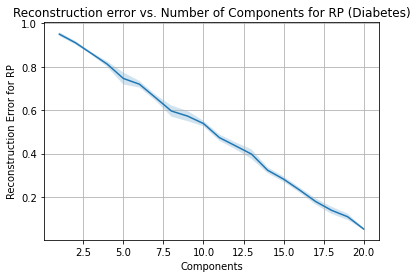

In [17]:
reconstruction_error = []
reconstruction_variance = []
for i in range(1,X.shape[1]):
    mean_mse = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        rp = GaussianRandomProjection(n_components=i)
        X_RP = rp.fit(X_train)
        w = X_RP.components_
        p = pinv(w)
        reconstructed = ((p@w)@(X_train.T)).T
        mean_mse.append(mean_squared_error(X_train,reconstructed))
    reconstruction_variance.append(np.std(mean_mse))
    reconstruction_error.append(np.mean(mean_mse))

reconstruction_error = np.array(reconstruction_error)
plt.plot(range(1, X.shape[1]),reconstruction_error)
plt.fill_between(range(1, X.shape[1]),reconstruction_error - reconstruction_variance, reconstruction_error + reconstruction_variance, alpha=0.2)
plt.xlabel('Components')
plt.ylabel('Reconstruction Error for RP')
plt.title(f'Reconstruction error vs. Number of Components for RP ({target_col})')
plt.grid()

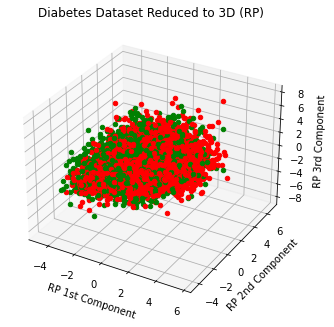

In [103]:
X_RP = GaussianRandomProjection(n_components = 10).fit_transform(X)
X_RP_train, X_RP_test, y_RP_train, y_RP_test = train_test_split(X_RP, y, test_size=0.3, random_state=0)
plot_3d(X_RP, y, target_col=target_col, dataset='RP')

$$ 9 \times \frac{1}{\epsilon^2-2\times\frac{\epsilon^3}{3}}\times log(M) + 1$$

# Feature Selection (Decision Tree)

Features selected: ['HighBP', 'BMI', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age', 'Education', 'Income']


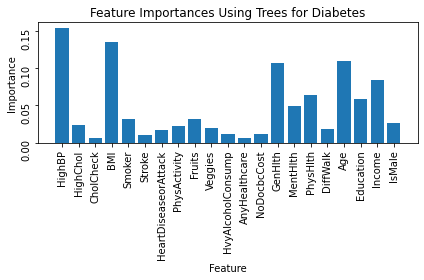

In [43]:
X_df = pd.DataFrame(X, columns=df.drop(target_col, axis=1).columns)

dt = DecisionTreeClassifier()
dt = dt.fit(X_df,y)
model = SelectFromModel(dt, prefit=True)
X_tree = model.transform(X_df)
feats = model.get_feature_names_out(X_df.columns)
print(f'Features selected: {[feat for feat in feats]}')
X_tree_train, X_tree_test, y_tree_train, y_tree_test = train_test_split(X_tree, y, test_size=0.3, random_state=0)
plt.bar(df.drop(target_col, axis=1).columns, dt.feature_importances_)
plt.xticks(range(df.shape[1]-1), df.drop(target_col, axis=1).columns)
plt.tick_params(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title(f'Feature Importances Using Trees for {target_col}')
plt.tight_layout();

# Clustering with Dimensionality Reduction
## k-Means

Inertia          :  41523.23032716078
Silhouette score :  0.27199407234691514
AMI score        :  0.13532576752291506
Cluster 0:
	True  : 76.0%
	False : 24.0%
Cluster 1:
	True  : 63.0%
	False : 37.0%
Cluster 2:
	True  : 20.0%
	False : 80.0%


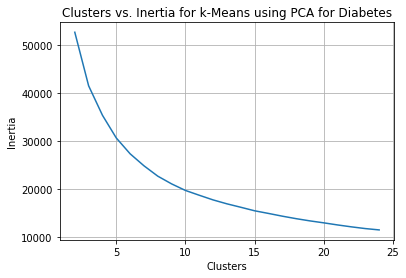

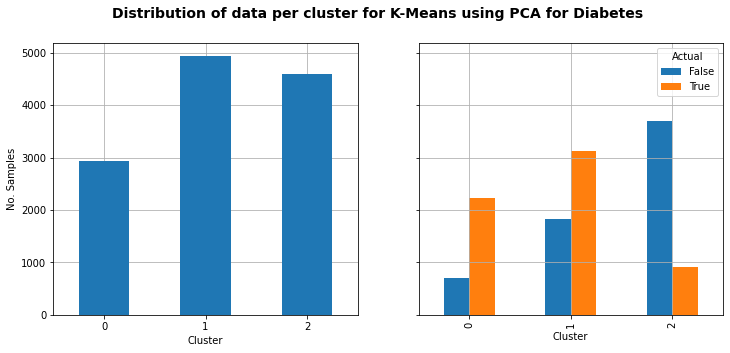

In [20]:
data_set = 'PCA'
plot_inertia(X_PCA, data_set, target_col)

k_means_clustering = plot_kmeans_cluster_dist(3, X_PCA, y, data_set, target_col)

get_cluster_breakdown(k_means_clustering.labels_, y)

Inertia          :  5.738956695097015
Silhouette score :  0.14692573254451669
AMI score        :  0.030176624519918233
Cluster 0:
	True  : 46.0%
	False : 54.0%
Cluster 1:
	True  : 56.0%
	False : 44.0%
Cluster 2:
	True  : 39.0%
	False : 61.0%
Cluster 3:
	True  : 27.0%
	False : 73.0%
Cluster 4:
	True  : 77.0%
	False : 23.0%
Cluster 5:
	True  : 57.0%
	False : 43.0%
Cluster 6:
	True  : 7.0%
	False : 93.0%


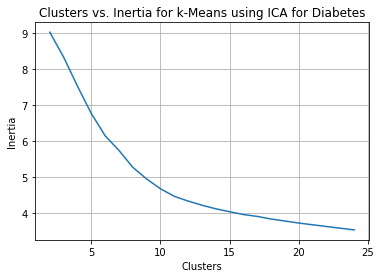

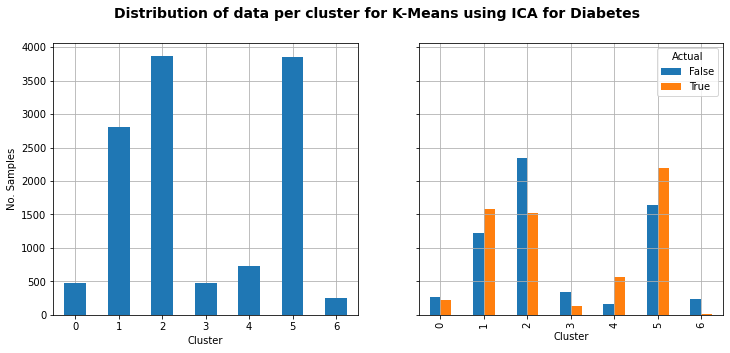

In [21]:
data_set = 'ICA'
plot_inertia(X_ICA, data_set, target_col)

k_means_clustering = plot_kmeans_cluster_dist(7, X_ICA, y, data_set, target_col)

get_cluster_breakdown(k_means_clustering.labels_, y)

Inertia          :  121562.7099298422
Silhouette score :  0.25175559478887927
AMI score        :  0.0076007993054329195
Cluster 0:
	True  : 58.0%
	False : 42.0%
Cluster 1:
	True  : 50.0%
	False : 50.0%
Cluster 2:
	True  : 34.0%
	False : 66.0%
Cluster 3:
	True  : 48.0%
	False : 52.0%


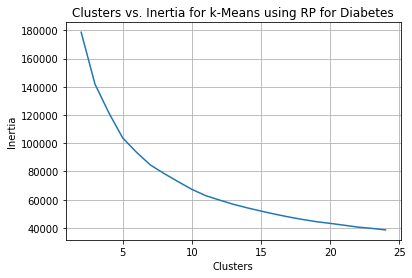

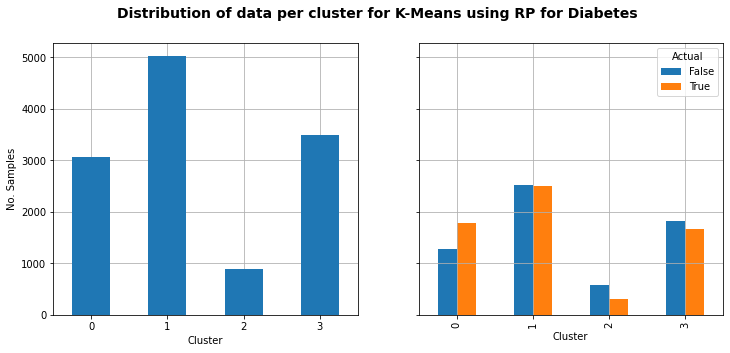

In [22]:
data_set = 'RP'
plot_inertia(X_RP, data_set, target_col)

k_means_clustering = plot_kmeans_cluster_dist(4, X_RP, y, data_set, target_col)

get_cluster_breakdown(k_means_clustering.labels_, y)

Inertia          :  49654.16508247182
Silhouette score :  0.2125923230316593
AMI score        :  0.10107897770409457
Cluster 0:
	True  : 74.0%
	False : 26.0%
Cluster 1:
	True  : 69.0%
	False : 31.0%
Cluster 2:
	True  : 21.0%
	False : 79.0%
Cluster 3:
	True  : 59.0%
	False : 41.0%


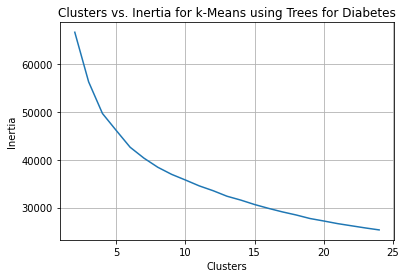

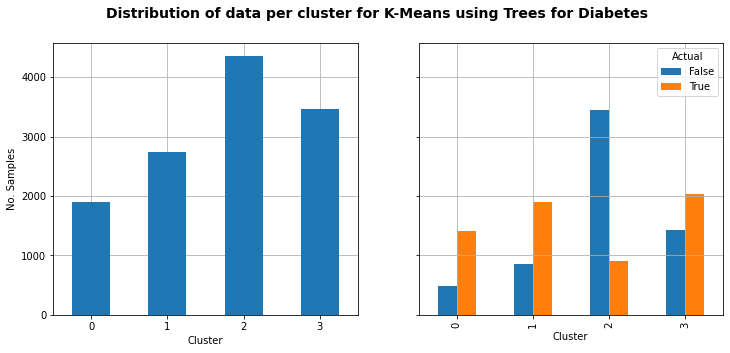

In [23]:
data_set = 'Trees'
plot_inertia(X_tree, data_set, target_col)

k_means_clustering = plot_kmeans_cluster_dist(4, X_tree, y, data_set, target_col)

get_cluster_breakdown(k_means_clustering.labels_, y)

## GMM

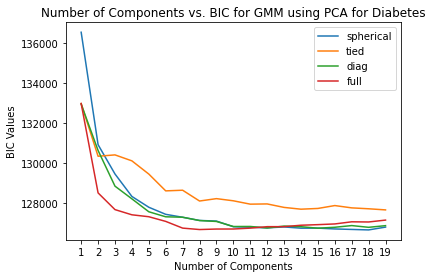

Silhouette score :  0.23216919872029926
AMI score        :  0.0799647249041822


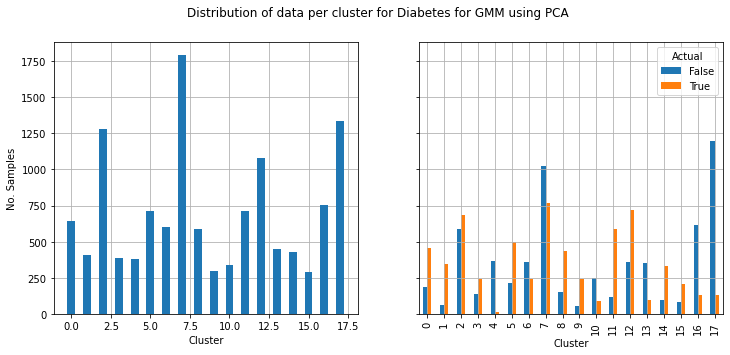

In [24]:
model_name = 'GMM'
data_set = 'PCA'

best_gmm, bic = run_gmm(X_PCA)
plot_bic(bic, model_name, data_set, target_col)
plot_cluster_dist(best_gmm, X_PCA, y, model_name, data_set, target_col)

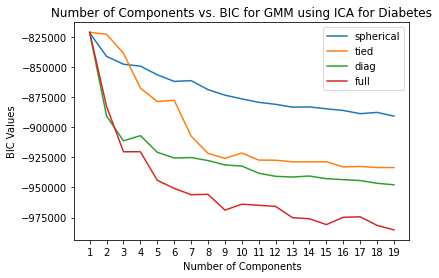

Silhouette score :  0.10406700016388949
AMI score        :  0.028385788464321444


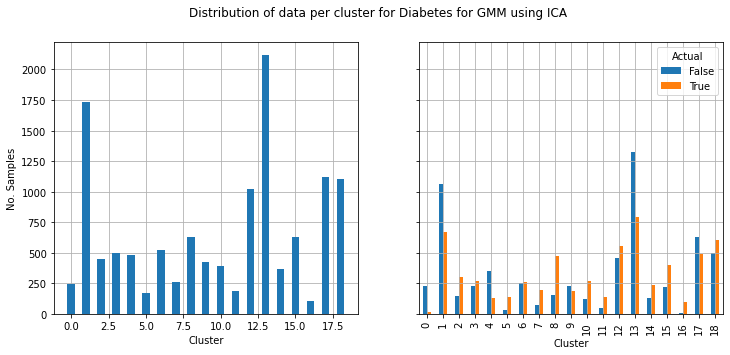

In [25]:
data_set = 'ICA'

best_gmm, bic = run_gmm(X_ICA)
plot_bic(bic, model_name, data_set, target_col)
plot_cluster_dist(best_gmm, X_ICA, y, model_name, data_set, target_col)

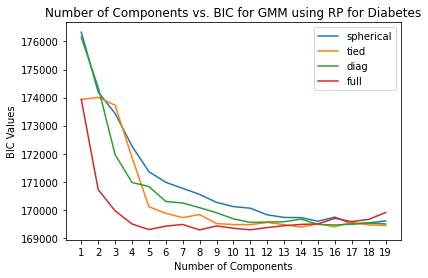

Silhouette score :  0.20038658063525464
AMI score        :  0.05486191257735416


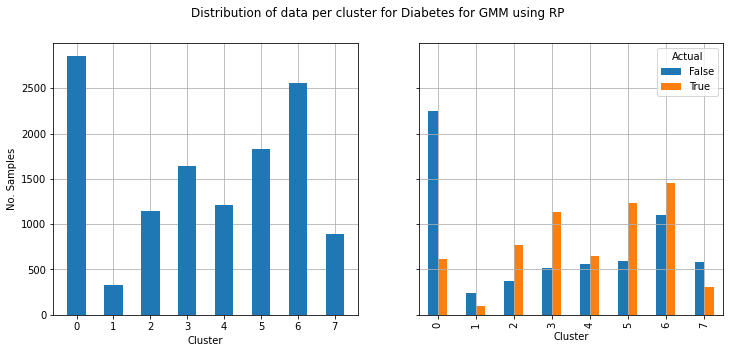

In [26]:
data_set = 'RP'

best_gmm, bic = run_gmm(X_RP)
plot_bic(bic, model_name, data_set, target_col)
plot_cluster_dist(best_gmm, X_RP, y, model_name, data_set, target_col)

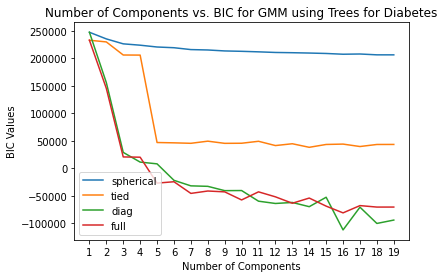

Silhouette score :  0.04139640716357782
AMI score        :  0.06221544294331821


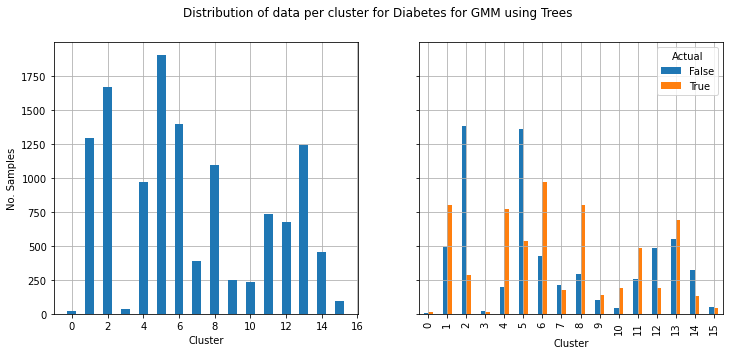

In [27]:
data_set = 'Trees'

best_gmm, bic = run_gmm(X_tree)
plot_bic(bic, model_name, data_set, target_col)
plot_cluster_dist(best_gmm, X_tree, y, model_name, data_set, target_col)

# Training Neural Network

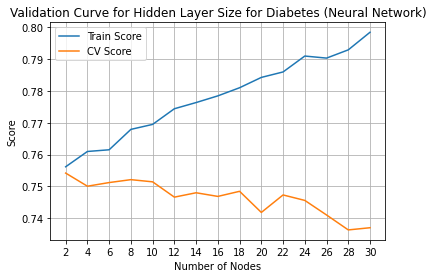

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

nn_classifier = MLPClassifier(random_state=0, max_iter=2000)
train_scores, test_scores = validation_curve(
    nn_classifier, 
    X_train, 
    y_train, 
    param_name="hidden_layer_sizes", 
    param_range=np.arange(2,31,2), 
    cv=4
)

plt.figure()
plt.plot(np.arange(2,31,2), np.mean(train_scores, axis=1), label='Train Score')
plt.plot(np.arange(2,31,2), np.mean(test_scores, axis=1), label='CV Score')
plt.legend()
plt.title(f"Validation Curve for Hidden Layer Size for {target_col} (Neural Network)")
plt.xlabel("Number of Nodes")
plt.ylabel("Score")
plt.grid()
plt.xticks(np.arange(2,31,2))
plt.show()

In [29]:
metrics = []
param_grid = {
    'alpha'              : np.logspace(-3,3,7), 
    'hidden_layer_sizes' : np.arange(2,25,2)
}
ls = np.linspace(0.1,1.0,10)

In [31]:
def plot_learning_loss_curves(ls, nn, X_train, y_train, dataset, target_col):
    _, train_scores, test_scores = learning_curve(
        nn, 
        X_train, 
        y_train, 
        train_sizes=ls, 
        cv=4
    )
    
    nn.fit(X_train, y_train)
    nn.loss_curve_
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
    ax1.plot(ls*100, np.mean(train_scores, axis=1), label='Train Score')
    ax1.plot(ls*100, np.mean(test_scores, axis=1), label='CV Score')
    ax1.legend()
    ax1.set_title(f"Learning Curve (Neural Network)\nUsing {dataset} for {target_col}")
    ax1.set_xlabel("Percentage of Training Examples")
    ax1.set_ylabel("Score")
    ax1.set_xticks(ls*100)
    ax1.grid()
    
    ax2.plot(nn.loss_curve_)
    ax2.set_title(f'Loss Curve (Neural Network)\nUsing {dataset} for {target_col}')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.grid()

Best params for neural network: {'alpha': 1.0, 'hidden_layer_sizes': 14}
Time to train: 405.9666130542755
Accuracy for best neural network: 0.7665775401069519
Time to infer: 0.0


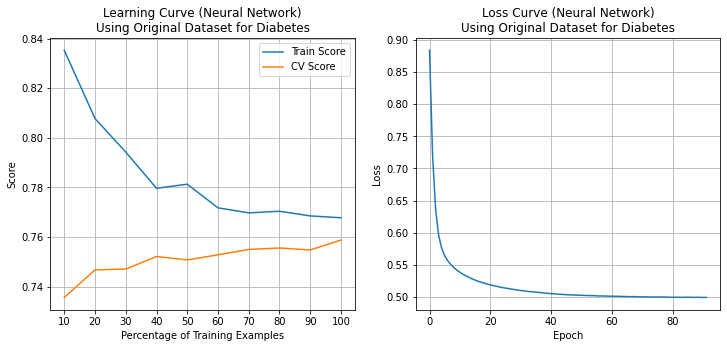

In [32]:
orig_nn_gs, train_time, pred_time, acc = nn_gs(param_grid, X_train, y_train, X_test, y_test, nn_classifier)
metrics.append({
    'Model'      : 'Original',
    'Train Time' : train_time, 
    'Pred Time'  : pred_time, 
    'Accuracy'   : acc
})

orig_nn = MLPClassifier(
    random_state       = 0, 
    max_iter           = 2000, 
    hidden_layer_sizes = orig_nn_gs.best_params_['hidden_layer_sizes'], 
    alpha              = orig_nn_gs.best_params_['alpha']
)
orig_nn.fit(X_train, y_train)
plot_learning_loss_curves(ls, orig_nn, X_train, y_train, 'Original Dataset', target_col)

## PCA w NN

In [ ]:
nn_classifier_pca = MLPClassifier(random_state=0, max_iter=2000)
nn_gs_pca, train_time, pred_time, acc = nn_gs(
    param_grid, 
    X_PCA_train,y_PCA_train, 
    X_PCA_test, y_PCA_test, 
    nn_classifier_pca
)
metrics.append({'Model':'PCA','Train Time':train_time, 'Pred Time':pred_time, 'Accuracy':acc})
nn_classifier_pca = MLPClassifier(
    random_state       = 0, 
    max_iter           = 2000, 
    hidden_layer_sizes = nn_gs_pca.best_params_['hidden_layer_sizes'], 
    alpha              = nn_gs_pca.best_params_['alpha']
)
nn_classifier_pca.fit(X_PCA_train, y_PCA_train)
plot_learning_loss_curves(ls, nn_classifier_pca, X_PCA_train, y_PCA_train, 'PCA', target_col)

## ICA w NN

In [ ]:
nn_classifier_ica = MLPClassifier(random_state=0, max_iter=2000)
nn_gs_ica, train_time, pred_time, acc = nn_gs(
    param_grid, 
    X_ICA_train, y_ICA_train, 
    X_ICA_test, y_ICA_test, 
    nn_classifier_ica
)
metrics.append({'Model':'ICA','Train Time':train_time, 'Pred Time':pred_time, 'Accuracy':acc})

nn_classifier_ica = MLPClassifier(
    random_state       = 0, 
    max_iter           = 2000, 
    hidden_layer_sizes = nn_gs_ica.best_params_['hidden_layer_sizes'], 
    alpha              = nn_gs_ica.best_params_['alpha']
)
nn_classifier_ica.fit(X_ICA_train, y_ICA_train)
plot_learning_loss_curves(ls, nn_classifier_ica, X_ICA_train, y_ICA_train, 'ICA', target_col)

## RP w NN

In [ ]:
nn_classifier_rp = MLPClassifier(random_state=0, max_iter=2000)
nn_gs_rp, train_time, pred_time, acc = nn_gs(
    param_grid, 
    X_RP_train, y_RP_train, 
    X_RP_test, y_RP_test, 
    nn_classifier_rp
)
metrics.append({'Model':'RP','Train Time':train_time, 'Pred Time':pred_time, 'Accuracy':acc})

nn_classifier_rp = MLPClassifier(
    random_state       = 0, 
    max_iter           = 2000, 
    hidden_layer_sizes = nn_gs_rp.best_params_['hidden_layer_sizes'], 
    alpha              = nn_gs_rp.best_params_['alpha']
)
nn_classifier_rp.fit(X_RP_train, y_RP_train)
plot_learning_loss_curves(ls, nn_classifier_rp, X_RP_train, y_RP_train, 'RP', target_col)

## DT w NN

In [ ]:
nn_classifier_dt = MLPClassifier(random_state=0, max_iter=2000)
nn_gs_dt, train_time, pred_time, acc = nn_gs(
    param_grid, 
    X_tree_train, y_tree_train, 
    X_tree_test, y_tree_test, 
    nn_classifier_dt
)
metrics.append({'Model':'DT','Train Time':train_time, 'Pred Time':pred_time, 'Accuracy':acc})

nn_classifier_dt = MLPClassifier(
    random_state       = 0, 
    max_iter           = 2000, 
    hidden_layer_sizes = nn_gs_dt.best_params_['hidden_layer_sizes'], 
    alpha              = nn_gs_dt.best_params_['alpha']
)
nn_classifier_dt.fit(X_tree_train, y_tree_train)
plot_learning_loss_curves(ls, nn_classifier_dt, X_tree_train, y_tree_train, 'DT', target_col)

## kMeans w NN

In [ ]:
k = 6
km = KMeans(n_clusters=k, random_state=0)
X_km = np.append(X, km.fit_transform(X), 1)
X_km_train, X_km_test, y_km_train, y_km_test = train_test_split(X_km, y, test_size=0.3, random_state=0)

nn_classifier_km = MLPClassifier(random_state=0, max_iter=2000)
nn_gs_km, train_time, pred_time, acc = nn_gs(
    param_grid, 
    X_km_train, y_km_train, 
    X_km_test, y_km_test, 
    nn_classifier_km
)
metrics.append({'Model':'kMeans','Train Time':train_time, 'Pred Time':pred_time, 'Accuracy':acc})

nn_classifier_km = MLPClassifier(
    random_state       = 0, 
    max_iter           = 2000, 
    hidden_layer_sizes = nn_gs_km.best_params_['hidden_layer_sizes'], 
    alpha              = nn_gs_km.best_params_['alpha']
)
nn_classifier_km.fit(X_km_train, y_km_train)
plot_learning_loss_curves(ls, nn_classifier_km, X_km_train, y_km_train, 'kMeans', target_col)

## EM w NN

In [ ]:
gmm = GaussianMixture(n_components=2, covariance_type='full')
gmm.fit(X)
X_GMM = np.append(X, gmm.predict_proba(X), 1)
X_GMM_train, X_GMM_test, y_GMM_train, y_GMM_test = train_test_split(X_GMM, y, test_size=0.3, random_state=0)

nn_classifier_gmm = MLPClassifier(random_state=0, max_iter=2000)
nn_gs_gmm, train_time, pred_time, acc = nn_gs(
    param_grid, 
    X_GMM_train, y_GMM_train, 
    X_GMM_test, y_GMM_test, 
    nn_classifier_gmm
)
metrics.append({'Model':'GMM','Train Time':train_time, 'Pred Time':pred_time, 'Accuracy':acc})

nn_classifier_gmm = MLPClassifier(
    random_state       = 0, 
    max_iter           = 2000, 
    hidden_layer_sizes = nn_gs_gmm.best_params_['hidden_layer_sizes'], 
    alpha              = nn_gs_gmm.best_params_['alpha']
)
nn_classifier_gmm.fit(X_GMM_train, y_GMM_train)

# plotting learning curve 
plot_learning_loss_curves(ls, nn_classifier_gmm, X_GMM_train, y_GMM_train, 'GMM', target_col)

In [ ]:
pd.DataFrame(metrics).groupby('Model').sum()['Train Time'].plot.bar(
    title=f'Train Time for Techniques Against NN\nfor {target_col} Dataset',
    ylabel='Seconds'
);